In [1]:
import IPython.display as ipd
import numpy as np
import pyaudio, wave
import math
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from scipy.fftpack import idct

# Divide signal data into 20ms segements with 10ms interval for every two consecutive ones 
def create_segments(signal,sample_rate,width=10):
    num=int(width*sample_rate/1000)
    ten_ms_segments = [signal[i:i+num] for i in range(0, len(signal), num)]
    twenty_ms_segments =[]
    for j in range(len(ten_ms_segments)):
        if j!=0:
            l1=ten_ms_segments[j-1]
            l2=ten_ms_segments[j]
            l=[0 for i in range(num*2)]
            for k in range(len(l1)):
                l[k]=l1[k]
                l[k+len(l1)]=l2[k]
            twenty_ms_segments.append(l)
    return twenty_ms_segments
# Preemphasize each segement
def Preemphasizing(chunk):
    pe=np.zeros(len(chunk))
    pe[0]=chunk[0]
    for i in range(1,len(chunk)):
        pe[i]=chunk[i]-0.95*chunk[i-1]
    return pe
# Window each preemphasized segement
def windowing(frame,mode="Hamming"):
    n=len(frame)
    if mode=="Hamming":
        frame=frame*np.hamming(n)
    elif mode=="Hanning":
        frame=frame*np.hanning(n)
    elif mode=="Blackman":
        frame=frame*np.blackman(n)
    return frame
# Zero pad each windowed segement
def zero_padding(frame,FFT_size=512):
    #zero padding for FFT
    frame_length=len(frame)
    padding_length=FFT_size-frame_length
    zeros=np.zeros((padding_length,))
    zero_padding_frame=np.concatenate((frame,zeros))
    return zero_padding_frame
# Calculate the power spectrum of a segement
def FFT(frame,FFT_size=512):
    mag_frame = np.absolute(np.fft.rfft(frame, FFT_size))
    power_spectrum = ((1.0 / FFT_size) * ((mag_frame) ** 2)) 
    return power_spectrum
# Mel warping function
def hztomel(f):
    z = 2595 * np.log10(1+f/700)
    return z
# inverse function
def meltohz(z):
    f = 700*(np.power(10,z/2595)-1)  
    return f
# calculate mel spectra and log mel spectra
def filterbanks(power_spectrum,lower_boundHz=133.33,upper_boundHz=6855.4976,num_banks=40,FFT_size=512):
    upper_boundMel=hztomel(upper_boundHz)
    lower_boundMel=hztomel(lower_boundHz)
    mel_points=np.linspace(lower_boundMel,upper_boundMel,num_banks+2)
    hz_points=meltohz(mel_points)
    bin=np.floor((FFT_size + 1)/2*hz_points/(upper_boundHz-lower_boundHz))
    bin=bin-bin[0]
    fbank=np.zeros((num_banks,int(np.floor(FFT_size/2+1))))
    for m in range(1,num_banks+1):
        f_m_low=int(bin[m-1])   
        f_m_center=int(bin[m])  
        f_m_up=int(bin[m+1])  
        for k in range(f_m_low,f_m_center):
            fbank[m-1,k]=(k-bin[m-1])/(bin[m]-bin[m-1])
        for k in range(f_m_center,f_m_up):
            fbank[m-1,k]=(bin[m+1]-k)/(bin[m+1]-bin[m])
    Fb=np.dot(power_spectrum,fbank.T)
    Fb=np.where(Fb==0,np.finfo(float).eps,Fb) 
    Log_Mel_spectrum=10*np.log(Fb) 
    return Fb,Log_Mel_spectrum
# use idct to get the cepstral_coefficients
def mel_cepstrum(log_mel_spectrum):
    cepstral_coefficients=idct(log_mel_spectrum, type=2, norm='ortho')
    return cepstral_coefficients[:13]
# get log mel spectrum matrix and mel cpestrum matrix, given segments
def get_two_matrix(segments):
    Mel_cepstrum_matrix=[]
    log_Mel_spectrum_matrix=[]
    for i in range(len(segments)):
        preemphasized=Preemphasizing(segments[i])
        windowed=windowing(preemphasized)
        zero_padded=zero_padding(windowed)
        power_spectrum=FFT(zero_padded)
        Mel_spectrum, log_Mel_spectrum=filterbanks(power_spectrum)
        log_Mel_spectrum_matrix.append(log_Mel_spectrum)
        Mel_cepstrum=mel_cepstrum(log_Mel_spectrum)
        Mel_cepstrum_matrix.append(Mel_cepstrum)
    return log_Mel_spectrum_matrix,Mel_cepstrum_matrix

In [2]:
# Load the WAV file
file_path = '1.wav'
wav_file = wave.open(file_path, 'r')

# Get the audio data
frames = wav_file.readframes(-1)
signal = np.frombuffer(frames, dtype=np.int16)

# Get the sample rate and time axis
sample_rate = wav_file.getframerate()
duration = len(signal) / sample_rate
time = np.linspace(0., duration, len(signal))

# Close the WAV file
wav_file.close()

# get segments from signal
seg=create_segments(signal,sample_rate)

# get two matrix from segments
log_mel_spectrum_matrix,mel_cepstrum_matrix=get_two_matrix(seg)

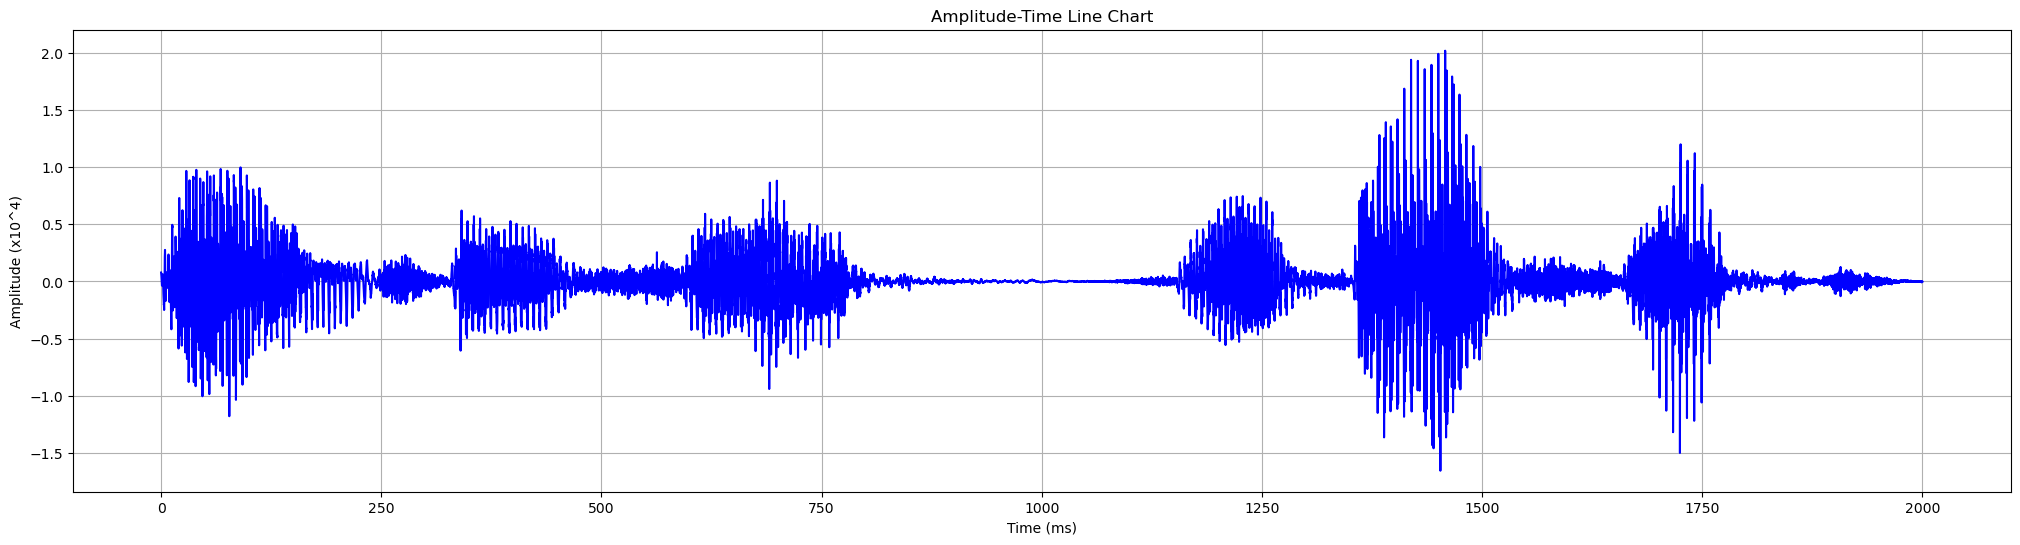

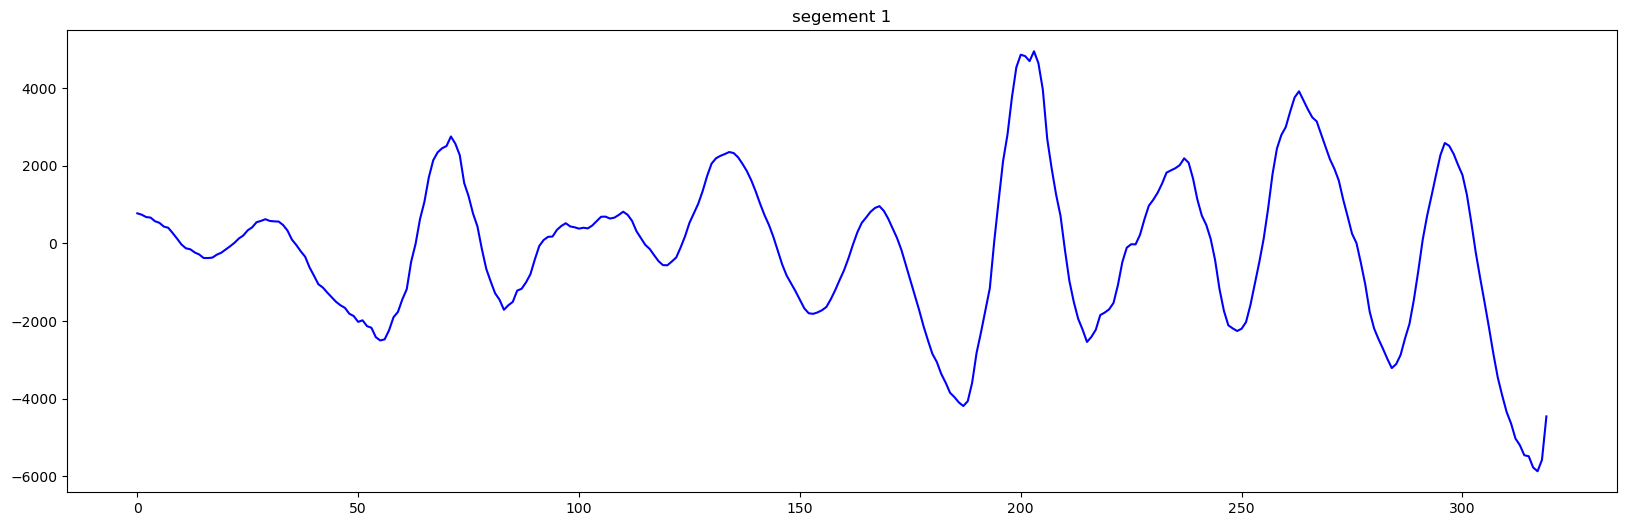

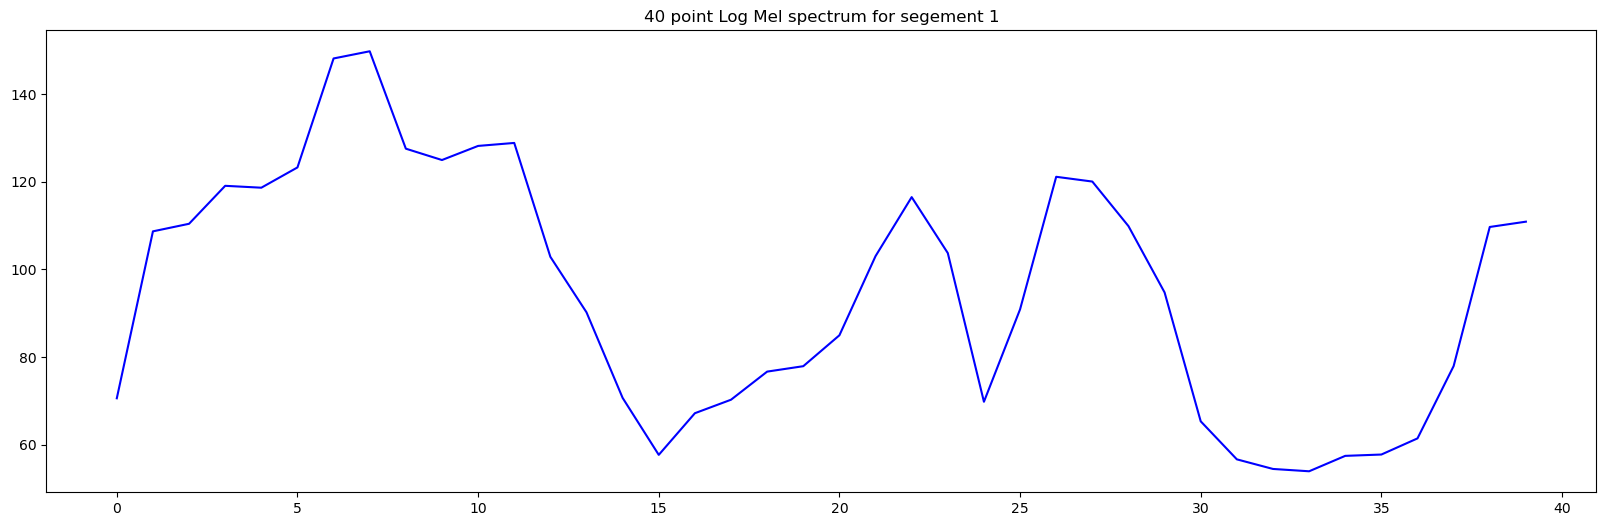

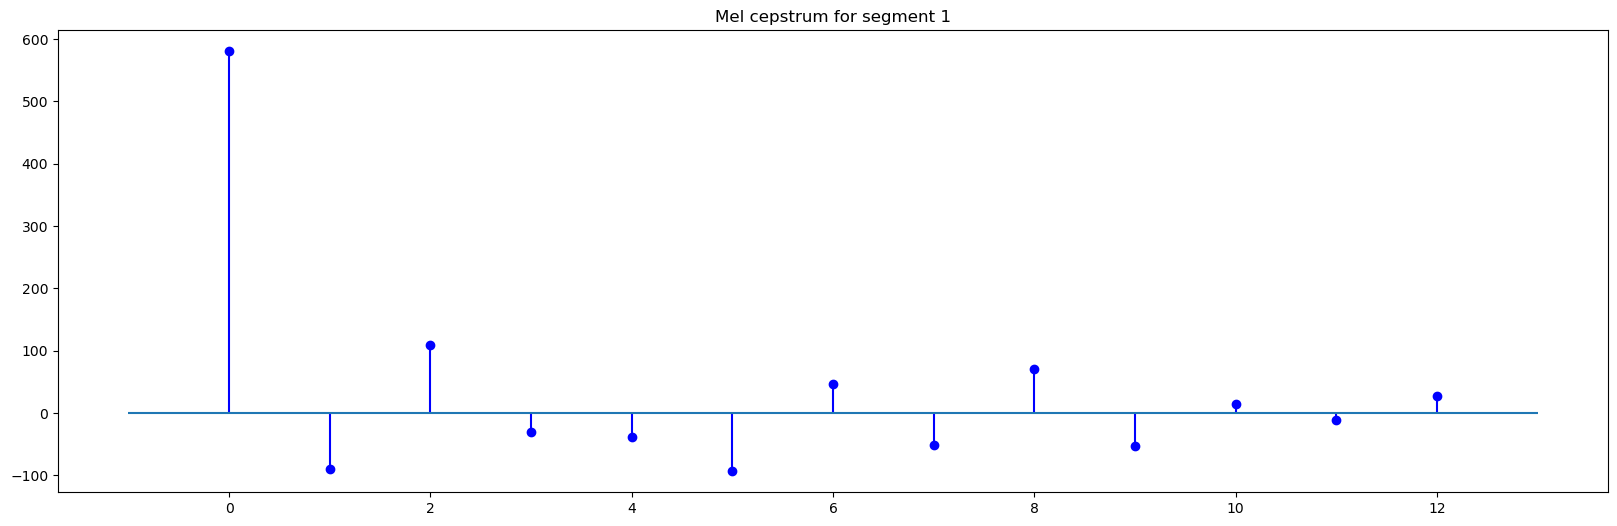

In [4]:
# Plot the amplitude-time line chart
plt.figure(figsize=(25, 6))
plt.plot(time*1000, signal/10000, color='blue')
plt.title('Amplitude-Time Line Chart')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (x10^4)')
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 6))
plt.plot([i for i in range(0,320)], seg[0], color='blue')
plt.title('segement 1')
plt.show()

#plot 40 point Log Mel spectrum for segement 1
plt.figure(figsize=(20, 6))
plt.plot([i for i in range(0,40)], log_mel_spectrum_matrix[0], color='blue')
plt.title('40 point Log Mel spectrum for segement 1')
plt.show()

# plot mel cepstrum for segment 1
plt.figure(figsize=(20, 6))
plt.scatter([i for i in range(0, 13)], mel_cepstrum_matrix[0], color='blue')
plt.title('Mel cepstrum for segment 1')

for i, y_value in enumerate(mel_cepstrum_matrix[0]):
    plt.vlines(x=i, ymin=0, ymax=y_value, color='b')
plt.hlines(y=0,xmin=-1,xmax=13)
plt.show()